In [1]:
import struct
from PIL import Image
import numpy as np

def read_record_ETL8G(f):
    s = f.read(8199)
    r = struct.unpack('>2H8sI4B4H2B30x8128s11x', s)
    iF = Image.frombytes('F', (128, 127), r[14], 'bit', 4)
    iL = iF.convert('L')
    return r + (iL,)

def read_kanji():
    kanji = np.zeros([883, 160, 127, 128], dtype=np.uint8)
    for i in range(1, 33):
        filename = 'D:/ETL8G/ETL8G_{:02d}'.format(i)
        with open(filename, 'rb') as f:
            for dataset in range(5):
                char = 0
                for j in range(956):
                    r = read_record_ETL8G(f)
                    if not (b'.HIRA' in r[2] or b'.WO.' in r[2]): 
                        kanji[char, (i - 1) * 5 + dataset] = np.array(r[-1])
                        char += 1
    np.savez_compressed("kanji.npz", kanji)

read_kanji()

KeyboardInterrupt: 

In [30]:
import skimage.transform
import numpy as np
from sklearn.model_selection import train_test_split

kanji = 879
rows = 127
cols = 128

kan = np.load("kanji.npz")['arr_0'].reshape([-1, 127, 128]).astype(np.float32)

kan = kan/np.max(kan)

train_images_numbers = [26,64,159,210,323,330,333,397,484,614,687,754,797,880]

train_images = np.zeros([len(train_images_numbers) * 160, rows, cols], dtype=np.float32)


#train_labels_numbers = [26,64,158,209,321,328,331,394,480,610,683,750,793,876]

for i in range(len(train_images_numbers)):
	for j in range(160):
		train_images[i*160+j] = kan[train_images_numbers[i]*160+j]

train_labels_numbers = np.arange(len(train_images_numbers))
train_labels = np.repeat(train_labels_numbers, 160)

# 4 characters were actually hiragana, so delete these 4 extras
#for i in range( (kanji+4) * 160):
#	if int(i/160) != 88 and int(i/160) != 219 and int(i/160) != 349 and int(i/160) != 457:
#		if int(i/160) < 88:
#			train_images[i] = skimage.transform.resize(kan[i], (rows, cols))
#		if int(i/160) > 88 and int(i/160) < 219:
#			train_images[i-160] = skimage.transform.resize(kan[i], (rows, cols))
#		if int(i/160) > 219 and int(i/160) < 349:
#			train_images[i-320] = skimage.transform.resize(kan[i], (rows, cols))
#		if int(i/160) > 349 and int(i/160) < 457:
#			train_images[i-480] = skimage.transform.resize(kan[i], (rows, cols))
#		if int(i/160) > 457:
#			train_images[i-640] = skimage.transform.resize(kan[i], (rows, cols))

#writing to add cahnges aaaaaa

train_images, test_images, train_labels, test_labels = train_test_split(train_images, train_labels, test_size=0.2)

np.savez_compressed("kanji_train_images.npz", train_images)
np.savez_compressed("kanji_train_labels.npz", train_labels)
np.savez_compressed("kanji_test_images.npz", test_images)
np.savez_compressed("kanji_test_labels.npz", test_labels)





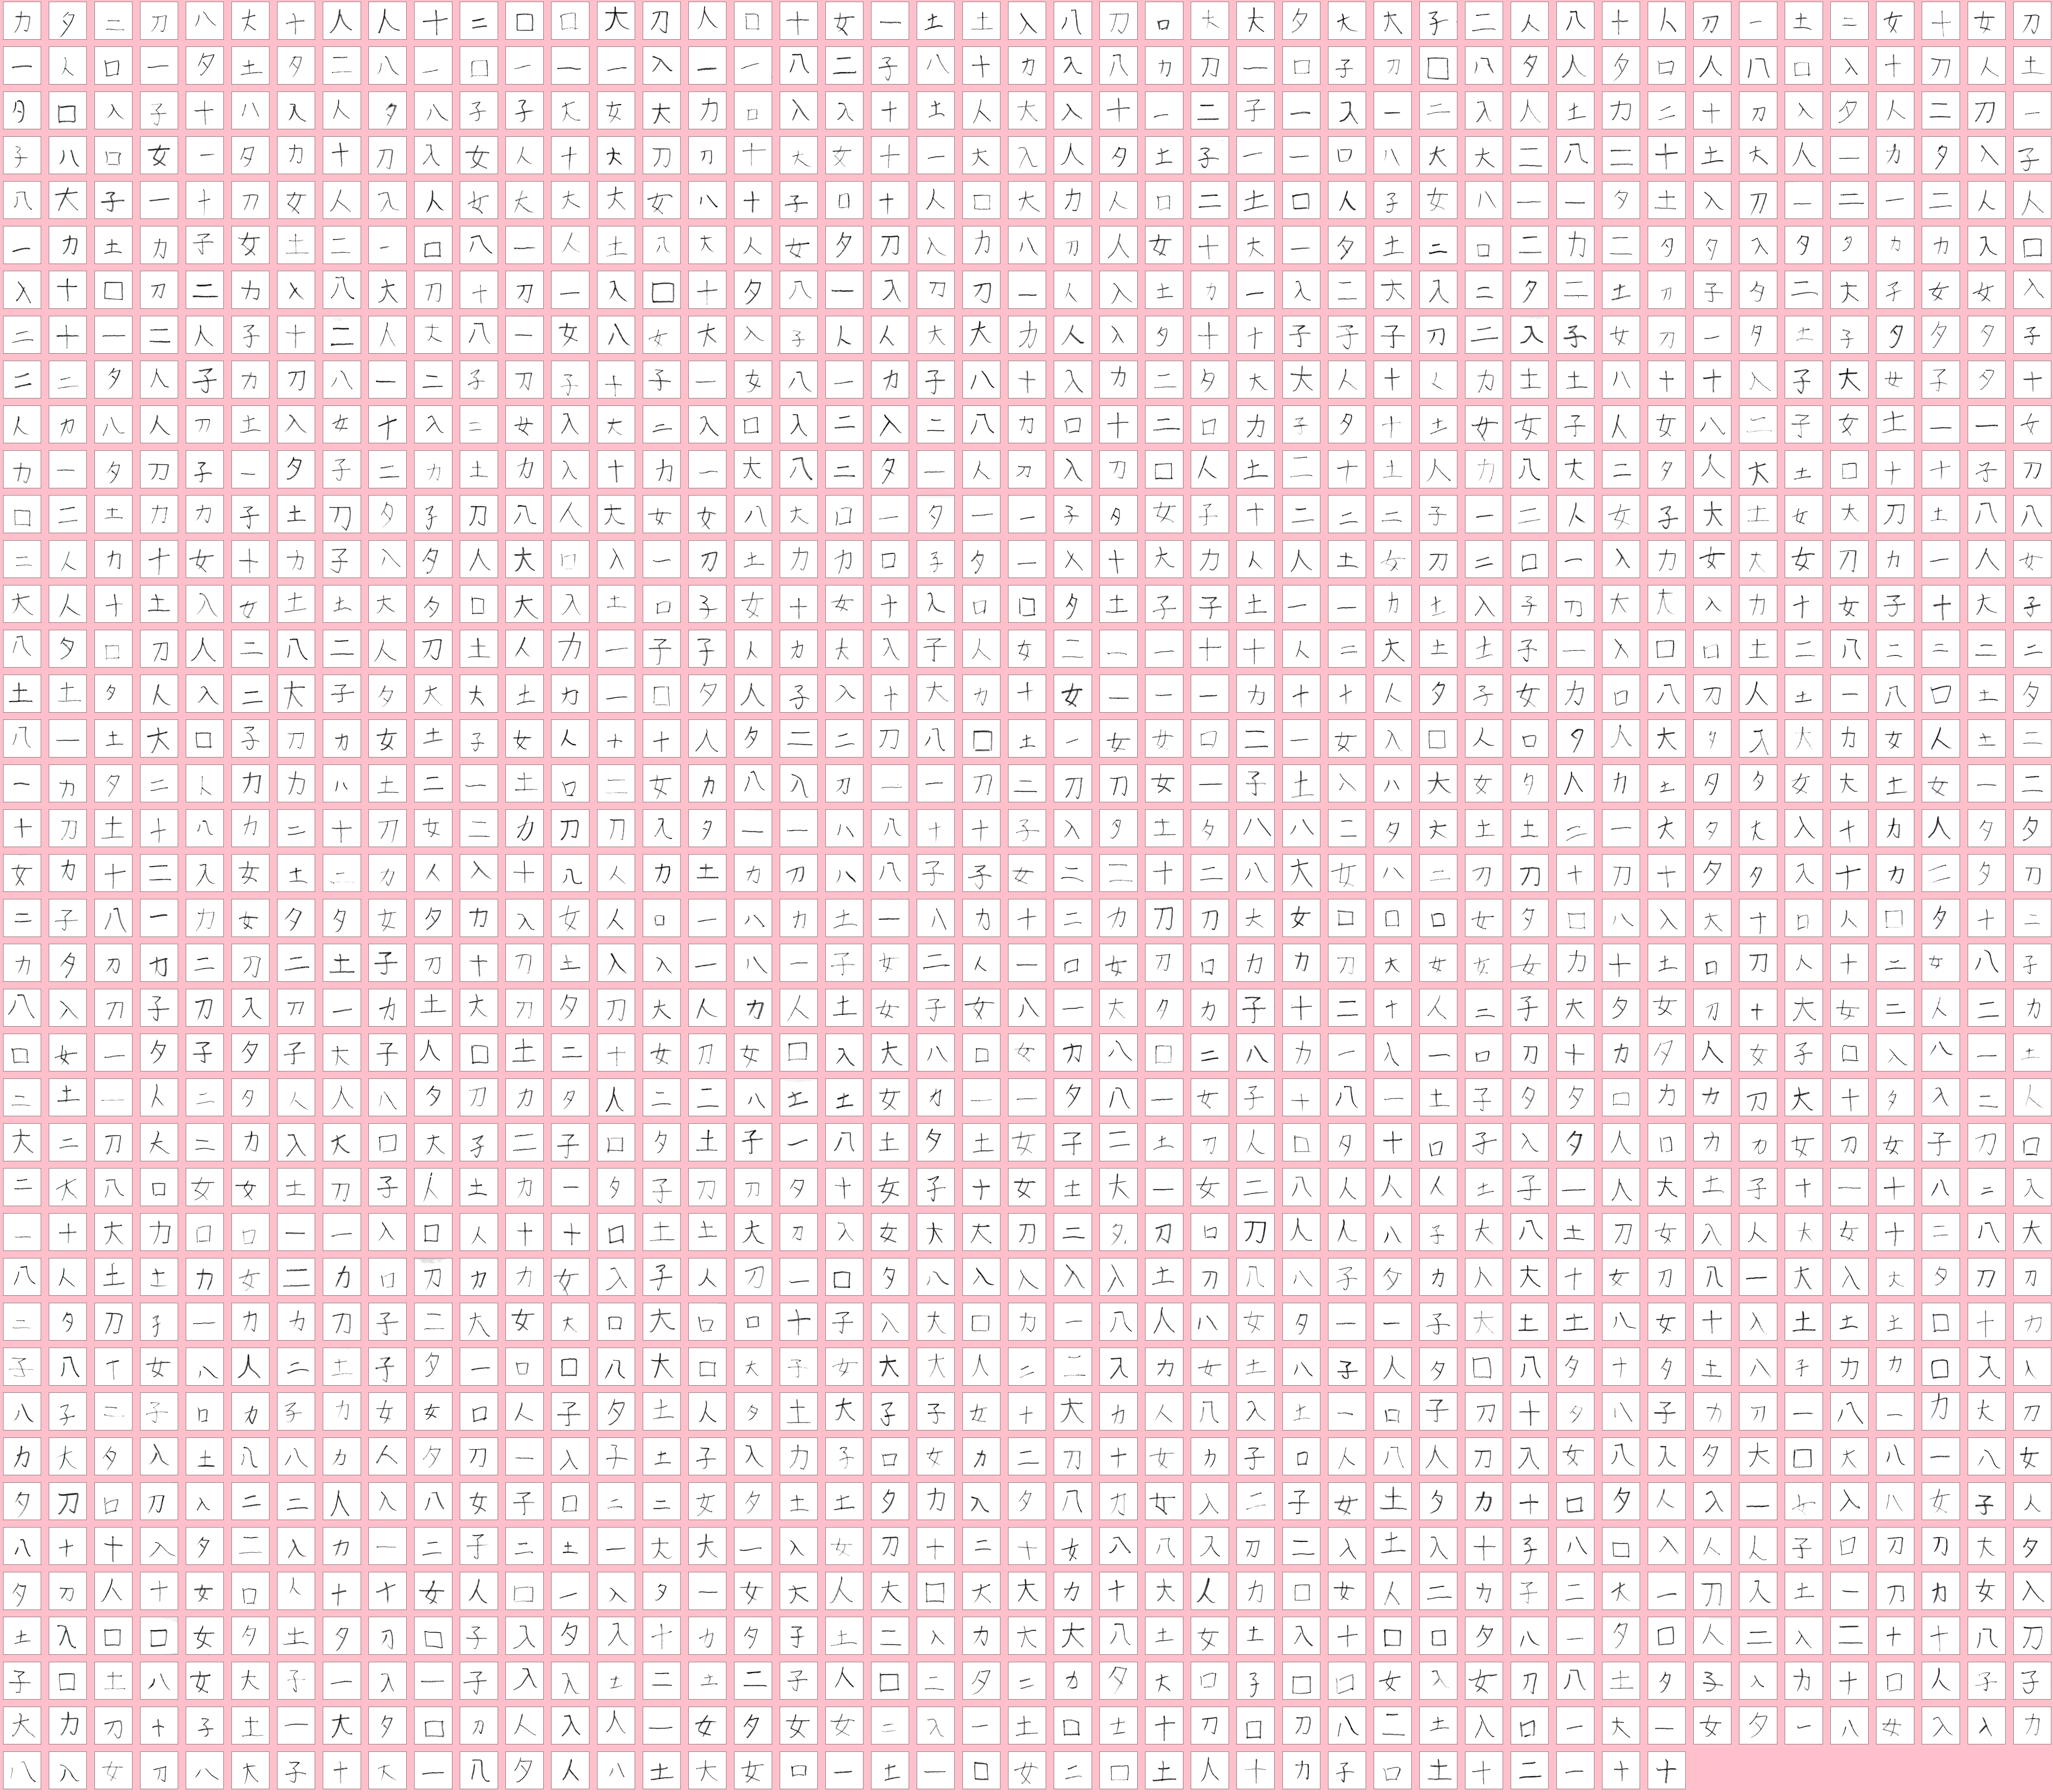

In [20]:
import matplotlib.pyplot as plt
plt.figure(figsize=(127,128)).patch.set_facecolor('pink')
for i in range(len(train_images_numbers)*128):
    plt.subplot(45,45,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
plt.show()

In [31]:
from tensorflow import keras
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

train_images = np.load("kanji_train_images.npz")['arr_0']
train_labels = np.load("kanji_train_labels.npz")['arr_0']
test_images = np.load("kanji_test_images.npz")['arr_0']
test_labels = np.load("kanji_test_labels.npz")['arr_0']

if K.image_data_format() == "channels_first":
  train_images = train_images.reshape(train_images.shape[0], 1,127,128)
  test_images = test_images.reshape(test_images.shape[0], 1,127,128)
  shape = (1,127,128)
else:
  train_images = train_images.reshape(train_images.shape[0], 127, 128, 1)
  test_images = test_images.reshape(test_images.shape[0], 127, 128, 1)
  shape = (127,128,1)
  
datagen = ImageDataGenerator(rotation_range=18,zoom_range=0.2)
datagen.fit(train_images)
model = keras.Sequential([
  #keras.layers.Conv2D(64, (3,3), activation='relu', ),
  #keras.layers.MaxPooling2D(2,2),
  keras.layers.Conv2D(40, (4,4), activation='relu',input_shape=shape),
  keras.layers.MaxPooling2D(2,2),
  keras.layers.Flatten(),
  #keras.layers.Dropout(0.5),
  #keras.layers.Dense(20, activation='relu'),
  keras.layers.Dense(14, activation="softmax")
])


model.summary()

model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=['accuracy'])
              
model.fit_generator(datagen.flow(train_images,train_labels,shuffle=True),epochs=50,validation_data=(test_images,test_labels),callbacks = [keras.callbacks.EarlyStopping(patience=8,verbose=1,restore_best_weights=True),keras.callbacks.ReduceLROnPlateau(factor=0.05,patience=3,verbose=1)])

test_loss, test_acc = model.evaluate(test_images, test_labels)
print("Test Accuracy: ", test_acc)

model.save("kanji.h5")

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_29 (Conv2D)          (None, 124, 125, 40)      680       
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 62, 62, 40)       0         
 g2D)                                                            
                                                                 
 flatten_22 (Flatten)        (None, 153760)            0         
                                                                 
 dense_57 (Dense)            (None, 14)                2152654   
                                                                 
Total params: 2,153,334
Trainable params: 2,153,334
Non-trainable params: 0
_________________________________________________________________


C:\Users\Pc\AppData\Local\Temp\ipykernel_12956\4151747291.py:38: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(datagen.flow(train_images,train_labels,shuffle=True),epochs=50,validation_data=(test_images,test_labels),callbacks = [keras.callbacks.EarlyStopping(patience=8,verbose=1,restore_best_weights=True),keras.callbacks.ReduceLROnPlateau(factor=0.05,patience=3,verbose=1)])


Epoch 1/50
56/56 [==============================] - 23s 370ms/step - loss: 1.3380 - accuracy: 0.5904 - val_loss: 0.7473 - val_accuracy: 0.7969 - lr: 0.0010
Epoch 2/50
56/56 [==============================] - 22s 360ms/step - loss: 0.7364 - accuracy: 0.7801 - val_loss: 0.6291 - val_accuracy: 0.8438 - lr: 0.0010
Epoch 3/50
56/56 [==============================] - 23s 383ms/step - loss: 0.6028 - accuracy: 0.8237 - val_loss: 0.5366 - val_accuracy: 0.8504 - lr: 0.0010
Epoch 4/50
56/56 [==============================] - 21s 361ms/step - loss: 0.5017 - accuracy: 0.8454 - val_loss: 0.4263 - val_accuracy: 0.8929 - lr: 0.0010
Epoch 5/50
56/56 [==============================] - 22s 361ms/step - loss: 0.4539 - accuracy: 0.8705 - val_loss: 0.3662 - val_accuracy: 0.9107 - lr: 0.0010
Epoch 6/50
56/56 [==============================] - 22s 359ms/step - loss: 0.3443 - accuracy: 0.9102 - val_loss: 0.3461 - val_accuracy: 0.9196 - lr: 0.0010
Epoch 7/50
56/56 [==============================] - 23s 385ms/st